In [1]:
%matplotlib inline
import os
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt

In [2]:
from mmctools.helper_functions import calc_wind
from mmctools.plotting import plot_profile, plot_timehistory_at_height, plot_timeheight, plot_spectrum
from windtools.SOWFA6.utils import InputFile

In [3]:
precdir = '/Users/equon/WakeDynamics/wakebench_simulations/Unstable_4km_precursor_updated'
solndir = '/Users/equon/WakeDynamics/wakebench_simulations/Unstable_4km_WT_270_updated_morefringe'
inflowplane = os.path.join('/Users/equon/analysis/WakeDynamics/wakebench_analysis/Debnath_LES',
                           'WAKEBENCH-NREL_DEBNATH_LES',
                           'unstable',
                           'NREL_DEBNATH_LES_20191021_uvw_-2.5D.nc')

In [4]:
wtstart = 12000.

In [5]:
# reference quantities
Uref = 6.7
thetaref = 290.9 # virtual potential temperature, measured near ground [K]
zi = 750. # inversion height, assumed in SOWFA [m]
hflux = 0.023 # surface heat flux [K-m/s]

## precursor planar averages

In [6]:
%%time
avg = pd.read_csv(os.path.join(precdir,'postProcessing','averaging.csv'))
avg = avg.rename(columns={'t':'time','z':'height'}).set_index(['time','height']).sort_index()

CPU times: user 2.43 s, sys: 461 ms, total: 2.89 s
Wall time: 1.87 s


In [7]:
avg['wspd'],avg['wdir'] = calc_wind(avg,u='U_mean',v='V_mean')

In [8]:
avg['k'] = 0.5*(avg['uu_mean'] + avg['vv_mean'] + avg['ww_mean'])

In [9]:
avg.columns

Index(['U_mean', 'V_mean', 'W_mean', 'T_mean', 'uu_mean', 'vv_mean', 'ww_mean',
       'uv_mean', 'uw_mean', 'vw_mean', 'R11_mean', 'R22_mean', 'R33_mean',
       'R12_mean', 'R13_mean', 'R23_mean', 'Tw_mean', 'q3_mean', 'wspd',
       'wdir', 'k'],
      dtype='object')

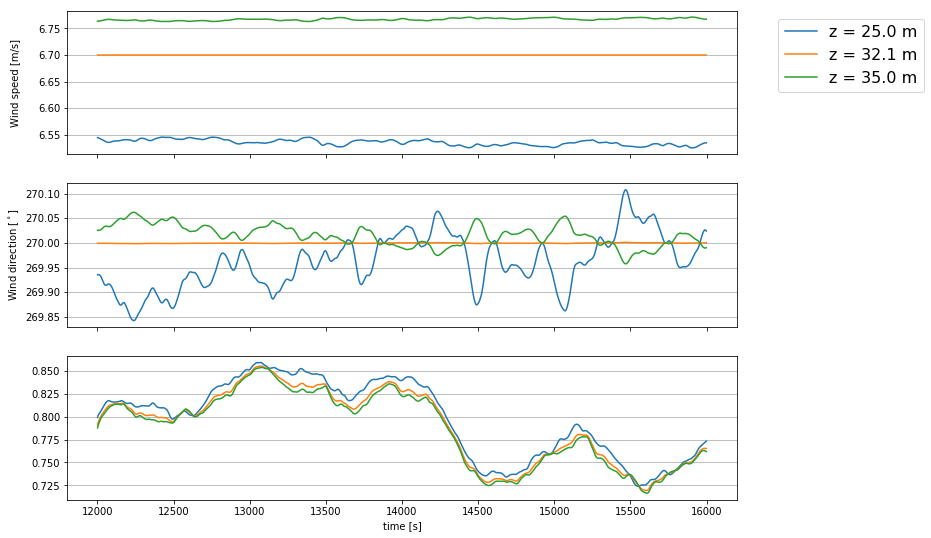

In [10]:
fig,ax = plot_timehistory_at_height(avg,fields=['wspd','wdir','k'],heights=[25,32.1,35])

## sources

In [11]:
%time sources = InputFile(os.path.join(solndir,'constant','sources'))

CPU times: user 2.19 s, sys: 29.4 ms, total: 2.22 s
Wall time: 2.22 s


In [12]:
tmp = np.array(sources['sourceTableMomentumX'])
t = tmp[:,0]
sourceUx = tmp[:,1]

tmp = np.array(sources['sourceTableMomentumY'])
assert np.all(tmp[:,0] == t)
sourceUy = tmp[:,1]

In [13]:
selected = (t >= wtstart)
t = t[selected]
sourceUx = sourceUx[selected]
sourceUy = sourceUy[selected]

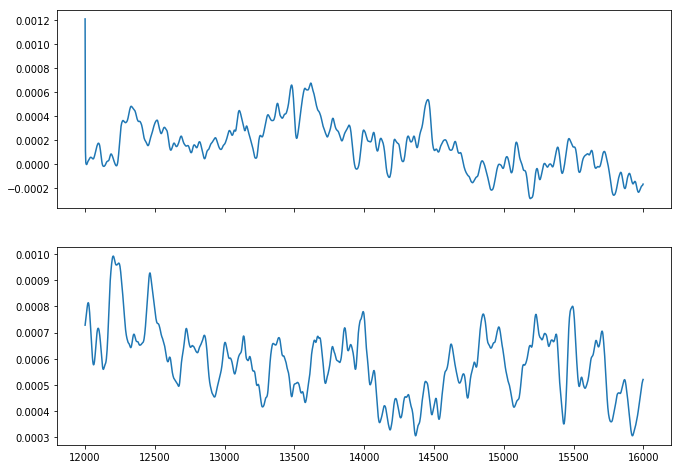

In [14]:
fig,ax = plt.subplots(nrows=2,sharex=True,figsize=(11,8))
ax[0].plot(t,sourceUx)
ax[1].plot(t,sourceUy)

## sampled inflow plane

In [15]:
%time inflow = xr.open_dataset(inflowplane)

CPU times: user 22.7 ms, sys: 6.12 ms, total: 28.8 ms
Wall time: 35 ms


In [16]:
inflow

<xarray.Dataset>
Dimensions:  (t: 1501, x: 1, y: 162, z: 162)
Coordinates:
  * t        (t) uint16 12400 12401 12402 12403 ... 13897 13898 13899 13900
  * x        (x) float64 -67.5
  * y        (y) float64 -40.0 -39.51 -39.01 -38.51 ... 38.51 39.01 39.51 40.0
  * z        (z) float64 0.4979 0.9949 1.492 1.989 ... 79.01 79.51 80.01 80.5
Data variables:
    U        (t, x, y, z) float64 ...
    V        (t, x, y, z) float64 ...
    W        (t, x, y, z) float64 ...

In [17]:
profile = inflow.mean(dim=['x','y'])
profile = profile.rename({'t':'time','z':'height'})
profile['wspd'],profile['wdir'] = calc_wind(profile,u='U',v='V')

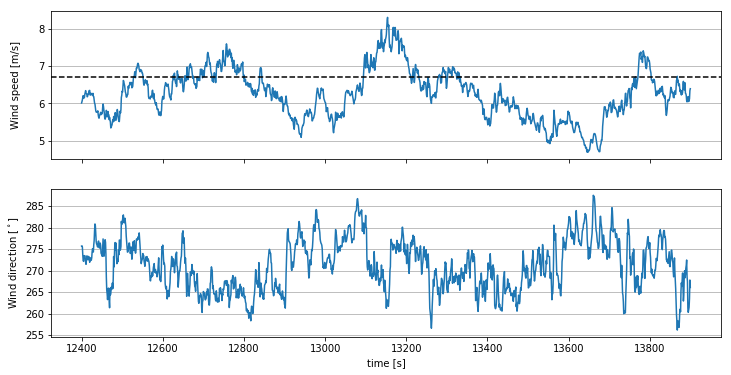

In [18]:
fig,ax = plot_timehistory_at_height(profile, fields=['wspd','wdir'], heights=32.1)
ax[0].axhline(Uref, color='k', ls='--')

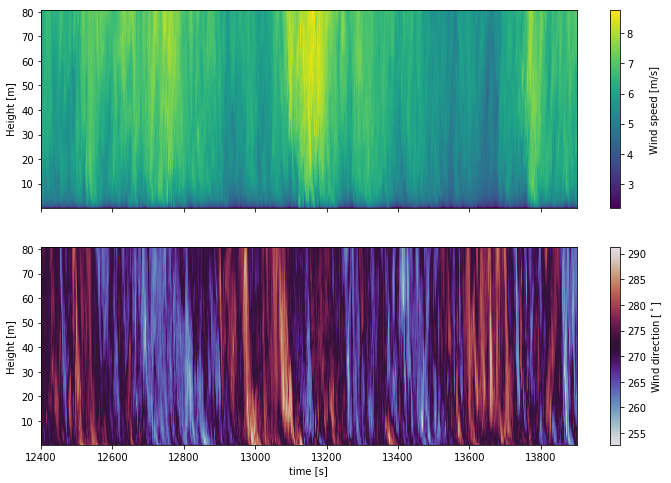

In [19]:
fig,ax,cbar = plot_timeheight(profile, fields=['wspd','wdir'])

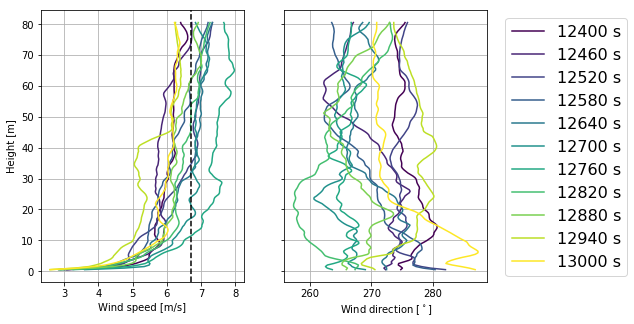

In [20]:
fig,ax = plot_profile(profile, fields=['wspd','wdir'],
                      times=np.arange(12400,13060,60),
                      cmap='viridis')
ax[0].axvline(Uref, color='k', ls='--')

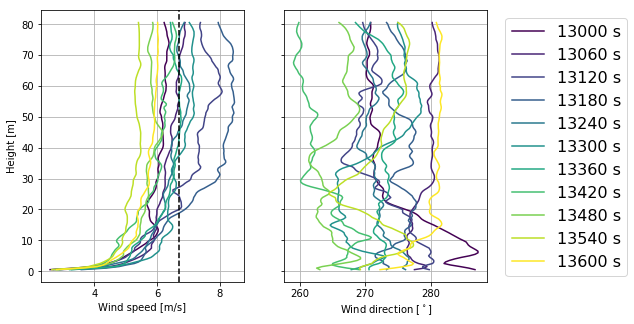

In [21]:
fig,ax = plot_profile(profile, fields=['wspd','wdir'],
                      times=np.arange(13000,13660,60),
                      cmap='viridis')
ax[0].axvline(Uref, color='k', ls='--')

### 10-min means

In [22]:
profile_10min = profile.rolling(time=600).mean()

Text(0.5, 0.98, '10-min mean')

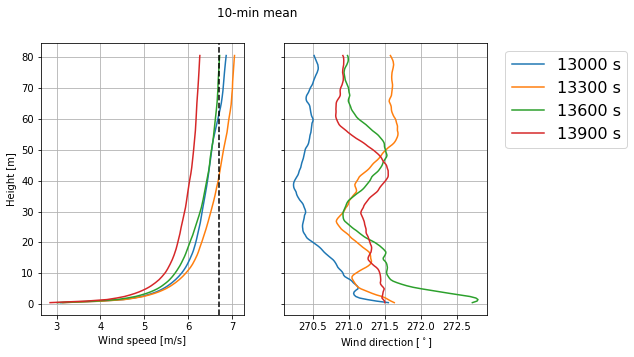

In [23]:
fig,ax = plot_profile(profile_10min, fields=['wspd','wdir'], times=[13000,13300,13600,13900])
ax[0].axvline(Uref, color='k', ls='--')
fig.suptitle('10-min mean')

### mean over all times

In [24]:
profile_mean = profile.mean(dim='time')

Text(0.5, 0.98, 'mean, all times')

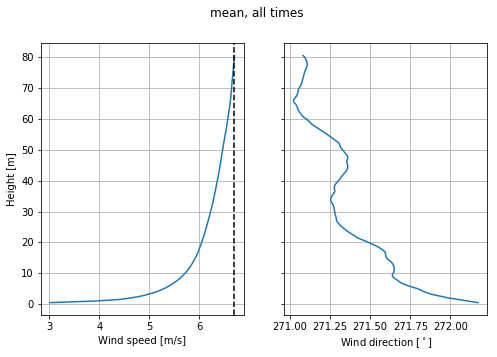

In [25]:
fig,ax = plot_profile(profile_mean, fields=['wspd','wdir'])
ax[0].axvline(Uref, color='k', ls='--')
fig.suptitle('mean, all times')

### 15-min means (period == the free-convection time scale)

In [26]:
wstar = (9.81*zi/thetaref*hflux)**(1/3)
wstar

0.8347788973271305

In [27]:
tstar = zi / wstar
tstar

898.4414943902115

In [28]:
profile['time']

<xarray.DataArray 'time' (time: 1501)>
array([12400, 12401, 12402, ..., 13898, 13899, 13900], dtype=uint16)
Coordinates:
  * time     (time) uint16 12400 12401 12402 12403 ... 13897 13898 13899 13900

In [29]:
profile_15min = profile.rolling(time=900).mean()

Text(0.5, 0.98, '15-min mean')

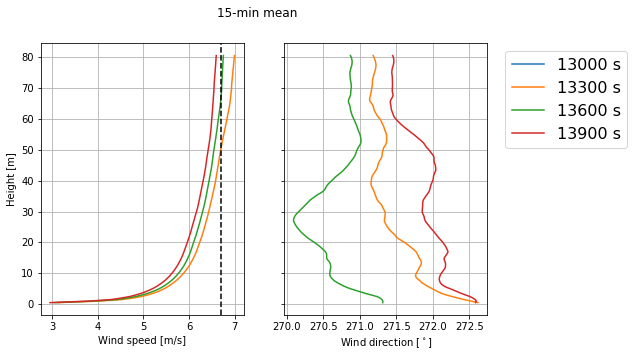

In [30]:
fig,ax = plot_profile(profile_15min, fields=['wspd','wdir'], times=[13000,13300,13600,13900])
ax[0].axvline(Uref, color='k', ls='--')
fig.suptitle('15-min mean')

### compare different means

In [31]:
profile

<xarray.Dataset>
Dimensions:  (height: 162, time: 1501)
Coordinates:
  * time     (time) uint16 12400 12401 12402 12403 ... 13897 13898 13899 13900
  * height   (height) float64 0.4979 0.9949 1.492 1.989 ... 79.51 80.01 80.5
Data variables:
    U        (time, height) float64 3.061 4.071 4.633 ... 6.989 6.984 6.977
    V        (time, height) float64 -0.255 -0.3578 -0.3841 ... 0.8916 0.895
    W        (time, height) float64 -0.007001 -0.01093 ... 0.5784 0.5841
    wspd     (time, height) float64 3.071 4.086 4.649 4.891 ... 7.046 7.04 7.034
    wdir     (time, height) float64 274.8 275.0 274.7 ... 262.8 262.7 262.7

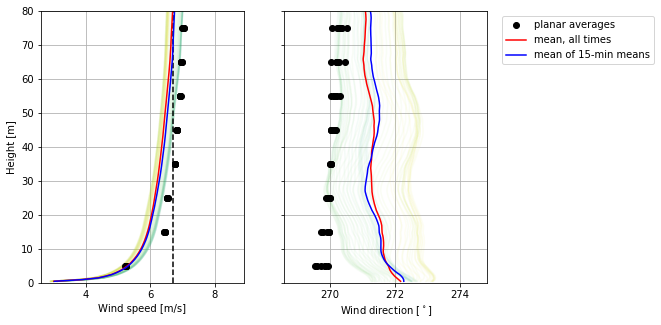

In [32]:
fig,ax = plot_profile(profile_15min, fields=['wspd','wdir'], times=np.arange(12400,13901,10),
                      cmap='viridis', alpha=0.05)
ax[0].axvline(Uref, color='k', ls='--')
plot_profile(avg, fields=['wspd','wdir'], times=range(12401,13902,300), heightlimits=(0,80),
             fig=fig, ax=ax, marker='o', linestyle='none', color='k')
handles, labels = ax[0].get_legend_handles_labels()

hmean, = ax[0].plot(profile_mean['wspd'], profile_mean.coords['height'], 'r')
ax[1].plot(profile_mean['wdir'], profile_mean.coords['height'], 'r')

# hmean10, = ax[0].plot(profile_10min['wspd'].mean(dim='time'), profile_10min.coords['height'], 'b')
# ax[1].plot(profile_10min['wdir'].mean(dim='time'), profile_10min.coords['height'], 'b')

hmean15, = ax[0].plot(profile_15min['wspd'].mean(dim='time'), profile_15min.coords['height'], 'b')
ax[1].plot(profile_15min['wdir'].mean(dim='time'), profile_15min.coords['height'], 'b')

ax[1].get_legend().remove()
ax[1].legend([handles[-1], hmean, hmean15],
             ['planar averages','mean, all times', 'mean of 15-min means'],
             loc='upper left', bbox_to_anchor=(1.05,1))

## compare time scales
Experiment: How does detrending affect spectra? Can the characteristic time (i.e., the convective time scale) be readily determined?

In [33]:
from mmctools.helper_functions import power_spectral_density

In [48]:
inflow_hub = inflow.sel(x=-67.5,z=32.3016).to_dataframe()['U'].unstack()
inflow_hub.head()

y,-40.0,-39.50999999999999,-39.00999999999999,-38.50999999999999,-38.01999999999998,-37.51999999999998,-37.01999999999998,-36.51999999999998,-36.02999999999997,-35.52999999999997,...,35.52999999999997,36.02999999999997,36.51999999999998,37.01999999999998,37.51999999999998,38.01999999999998,38.50999999999999,39.00999999999999,39.50999999999999,40.0
t,,,,,,,,,,,,,,,,,,,,,
12400,6.25453,6.25677,6.27795,6.29982,6.32838,6.35892,6.37722,6.39112,6.40218,6.40471,...,6.04504,6.04103,6.03914,6.04267,6.04013,6.03061,6.01514,5.98082,5.94407,5.90573
12401,6.37666,6.38613,6.40031,6.40916,6.42151,6.42883,6.41859,6.42233,6.42212,6.41279,...,6.13667,6.12038,6.09513,6.07789,6.05214,6.01257,5.96104,5.90308,5.83413,5.76730
12402,6.43410,6.45172,6.47181,6.49421,6.51370,6.53627,6.54390,6.56326,6.58360,6.59104,...,6.10330,6.05391,6.00715,5.97479,5.93934,5.89896,5.84967,5.79309,5.72046,5.64715
12403,6.57987,6.59728,6.63041,6.66338,6.70907,6.74374,6.75786,6.74300,6.73018,6.69647,...,6.05750,5.99390,5.94229,5.90328,5.86830,5.82137,5.76917,5.72063,5.66626,5.60863
12404,6.78021,6.78517,6.77778,6.77412,6.76935,6.76460,6.76914,6.79920,6.81058,6.80116,...,6.07015,6.01224,5.96021,5.91059,5.87104,5.82411,5.77498,5.72829,5.67762,5.62627


In [49]:
psd = power_spectral_density(inflow_hub)

In [53]:
inflow_hub_10min = inflow_hub - inflow_hub.rolling(600).mean()
psd_10min = power_spectral_density(inflow_hub_10min.iloc[600:])

In [57]:
inflow_hub_15min = inflow_hub - inflow_hub.rolling(900).mean()
psd_15min = power_spectral_density(inflow_hub_10min.iloc[900:])

In [68]:
%%time
from statsmodels.nonparametric.smoothers_lowess import lowess
inflow_hub_lowess = inflow_hub.copy()
for y in inflow_hub_lowess.columns:
    print('Smoothing',y)
    smoothed = lowess(inflow_hub_lowess[y], inflow_hub_lowess.index,
                      frac=2/3, it=3, # defaults
                      return_sorted=False
                     )
    inflow_hub_lowess[y] -= smoothed

Smoothing -40.0
Smoothing -39.50999999999999
Smoothing -39.00999999999999
Smoothing -38.50999999999999
Smoothing -38.01999999999998
Smoothing -37.51999999999998
Smoothing -37.01999999999998
Smoothing -36.51999999999998
Smoothing -36.02999999999997
Smoothing -35.52999999999997
Smoothing -35.02999999999997
Smoothing -34.539999999999964
Smoothing -34.039999999999964
Smoothing -33.539999999999964
Smoothing -33.049999999999955
Smoothing -32.549999999999955
Smoothing -32.049999999999955
Smoothing -31.559999999999945
Smoothing -31.059999999999945
Smoothing -30.559999999999945
Smoothing -30.059999999999945
Smoothing -29.569999999999936
Smoothing -29.069999999999936
Smoothing -28.569999999999936
Smoothing -28.079999999999927
Smoothing -27.579999999999927
Smoothing -27.079999999999927
Smoothing -26.589999999999918
Smoothing -26.089999999999918
Smoothing -25.589999999999918
Smoothing -25.09999999999991
Smoothing -24.59999999999991
Smoothing -24.09999999999991
Smoothing -23.59999999999991
Smoothin

In [69]:
psd_lowess = power_spectral_density(inflow_hub_lowess)

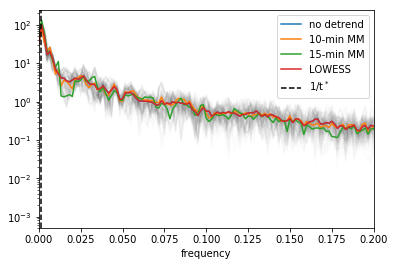

In [72]:
plt.semilogy(psd.index, psd.values,color='0.5',alpha=0.02,label='')
plotopts = dict(logy=True,legend=False)
psd.mean(axis=1).plot(**plotopts,label='no detrend')
psd_10min.mean(axis=1).plot(**plotopts,label='10-min MM')
psd_15min.mean(axis=1).plot(**plotopts,label='15-min MM')
psd_lowess.mean(axis=1).plot(**plotopts,label='LOWESS')
plt.xlim((0,0.2))
plt.gca().axvline(1/tstar, color='k', ls='--', label=r'1/t$^*$')
plt.legend()